# LSMLSDA Programming Exercise Week 1
## Modelling decision making with a drift-diffusion model

This exercise was kindly provided by Prof. Sprekeler, Modelling of Cognitive Processes Group, BCCN Berlin. 


We will explore the reaction time distribution of the drift diffusion model
for perceptual decision making. 

Relevant paper: https://www.ncbi.nlm.nih.gov/pubmed/17600525

General information: https://en.wikipedia.org/wiki/Two-alternative_forced_choice

In [1]:
# imports 
import matplotlib.pyplot as plt
import numpy as np
import warnings
from scipy.integrate import odeint
from tqdm import tqdm  # for progress bars (https://github.com/tqdm/tqdm) 

warnings.filterwarnings('ignore')
%matplotlib inline

# set plotting defaults
from matplotlib import rcParams
rcParams.update({'axes.titlesize' : 24,
                 'axes.labelsize' : 20,
                 'lines.linewidth' : 2,
                 'lines.markersize' : 7,
                 'xtick.labelsize' : 16,
                 'ytick.labelsize' : 16,
                 'legend.fontsize' : 15})

### Part 1
Our goal is to simulate a decision making process. A very much simplified approach to that is to simulate a biased random walk: We simulate an internal decision variable, e.g., some neural activity, using a single scalar variable. At every time step, the variable evolves in a certain direction due to sensory evidence for a decision in that direction (drift, $\mu$), plus noise (diffusion, $\sigma$). Such a model is often called a drift-diffusion model. A simple form of the drift diffusion model is given by

$$
dX = \mu \mathrm{dt} + \sigma \mathrm{dW} ,
$$

To simulate the decision making process as a drift-diffusion process we have to integrate this equation. Because it is a stochastic differential equation (sde) we cant use standard implementation like scipy odeint for integration. Therefore, your first task is to implement your own Euler-Marayuma sde solver.

Euler-Maruyama is an extension of the simple Euler method to stochastic differential equations where we here only consider Gaussian noise processes. Euler-Maruyama
integrates differential equations of the form

\begin{align}
dX(t) &= f(X(t))\mathrm{dt} + g(X(t))\mathrm{dW}(t)
\end{align}

here f (X(t)) is the deterministic part of the differential equation and g(X(t))dW (t) is
the stochastic part where dW (t) is a random variable. Euler-Maruyama consists of the
following update which your function has to implement:

\begin{align}
X_t = X_{t-1} + f(X_{t-1}) \Delta t + g(X_{t-1}) \sqrt{\Delta t} W_t
\end{align}

Each $W_t$ is a sample from a standard normal distribution. For more information about
Euler-Maruyama see Higham (2001), or Wikipedia.
Write a function euler_maruyama(ffun, gfun, x0, t, \**args) which implements this equation
and which behaves like scipy odeint. Note that we have defined args as a dictionary which differs
from scipy odeint where args is a tuple. This makes it easier to change individual parameters of
the model functions later.

Start with $X = 0$. Choose
$\sigma = 0.5, \mu = 0.2$. Run 5 simulations of 10 seconds length with $dt = 0.01s$ and
plot the results.

**Hint**: A single simulation is a trace of values starting at X=0 and evolving as a random walk with a drift towards more positive (or negative) values. Plot all 5 traces in a single plot with different colors. 

In [2]:
def euler_maruyama(ffun, gfun, x0, t, **args): 
    """Implements Euler Maruyama method for solving system of differential eqs. """
    # get the step size
    dt = t[1]
    # prelocate 
    sqrtdt = np.sqrt(dt)
    X = np.zeros((len(x0), len(t)))
    # set initial values 
    X[:,0] = x0
    # generate the noise 
    dW = sqrtdt*np.random.standard_normal((len(x0), len(t)))
    # iterate and apply update rule
    for i in range(len(t)-1):        
        X[:,i+1] = X[:,i] + np.array(ffun(X[:,i], **args))*dt + np.array(gfun(X[:,i], **args))*dW[:,i]
    # return in the odeint format: results in rows
    return X.T

def f_ddm(x, **args): 
    return mu

def g_ddm(x, **args): 
    return sigma

In [3]:
# Start with X = 0. Choose σ = 0.5, μ = 0.2.
dt = 0.01
t = np.arange(0, 10, dt)
mu = 0.2
sigma = 0.5
x0 = 0

# Run n_runs simulations of 10 seconds length with ∆t = 0.01s and plot the results.
n_runs = 5
xtraces = np.zeros((t.shape[0], n_runs))

for run_idx in range(n_runs): 
    xtraces[:, run_idx] = euler_maruyama(f_ddm, g_ddm, [x0], t, **dict([('mu',mu), ('sigma', sigma)])).squeeze()

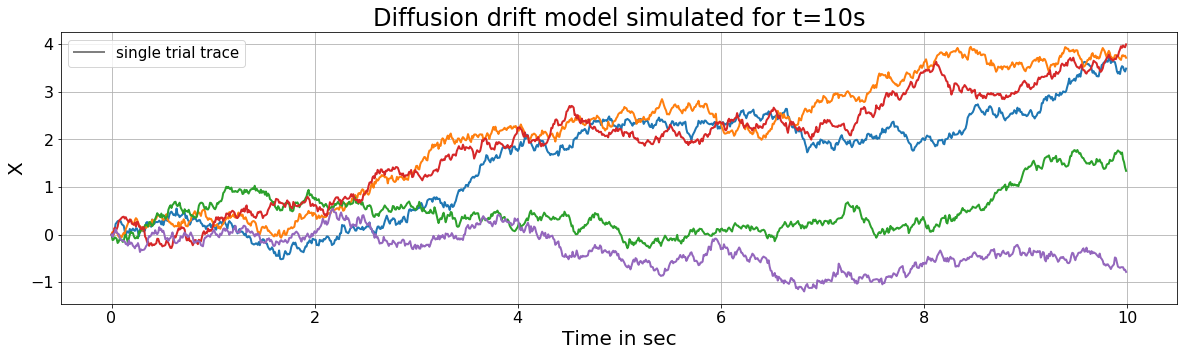

In [4]:
plt.figure(figsize=(20,5))
plt.plot(t, xtraces)
plt.xlabel("Time in sec")
plt.ylabel("X")
plt.title("Diffusion drift model simulated for t=10s")
leg = plt.legend(['single trial trace']);
leg.legendHandles[0].set_color('grey')
plt.grid();

### Part 2

Plot the percentage of ”up” (X=+a) responses as a function of the drift μ by
simulating 200 trials for a = 1 and the following $\mu$ values: −0.1, 0, 0.1, 0.2, 0.5.

Resimulate trials in which no decision boundary is reached during the simulation.

Plot the results. What happens to this curve if you double, what if you halve the
value of a?


In [5]:
def check_up_down(xtrace, bound): 
    """Checks for an 'up' response, returns 1 / 0 for up/down response. returns -1 if no decision bound was reached"""
    # if there are values in the simulation larger, equal to a, then the trial counts as 'up'
    if len(np.where(xtrace >= bound)[0]) > 0: 
        return 1
    elif len(np.where(xtrace <= -bound)[0]) > 0: 
        return 0
    else: 
        return -1
    
def simulate_ddm(mu, sigma, a): 
    """
    Simulate a ddm with globally defined t and dt. Resimulates if no decision was made. 
    """
    
    bound_crossed = False 
    # anker to avoid infinite loop
    anker = 1000 
    counter = 0 

    # simulate until decisive trial
    while (not bound_crossed and counter < anker): 
        # simulate 
        xtrace = euler_maruyama(f_ddm, g_ddm, [x0], t, **dict([('mu',mu), ('sigma',sigma)]))
        check = check_up_down(xtrace, bound=a)
        # trial was succesful if check return 0 or 1
        bound_crossed = check != -1
        anker += 1
    return xtrace, check

In [6]:
# simulating 400 trials
n_trials = 400 
a_s = np.array([0.5, 1, 2]) 
sigma = 0.5 
# take out mu=0 because it takes so long to re-simulate
mus = np.array([-0.1, 0.1, 0.2, 0.5])
ups = np.zeros((len(a_s), len(mus)))

# iterate through a's mus and trials
for i, a in enumerate(a_s): 
    for j, mu in enumerate(tqdm(mus, desc='mus')): 
        for trial in range(n_trials): 
            sol, check = simulate_ddm(mu, sigma, a)
            ups[i, j] += check

mus: 100%|██████████| 4/4 [00:23<00:00,  5.95s/it]


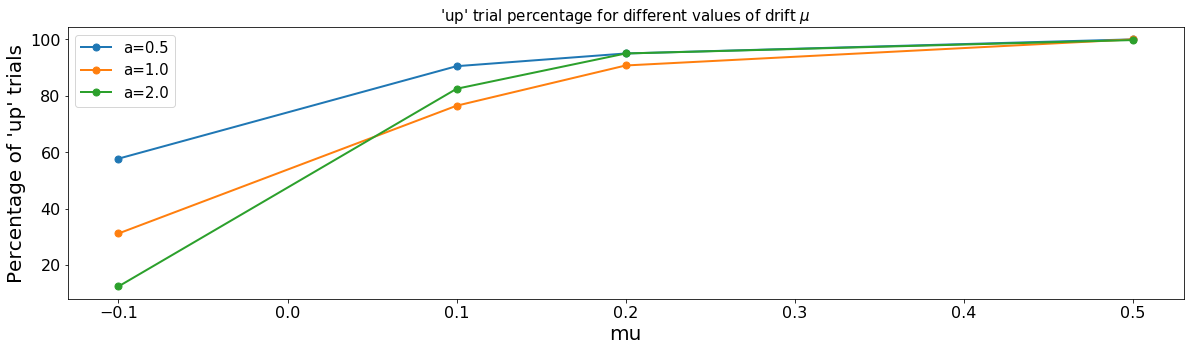

In [7]:
# Plot the percentage of ”up” (X=+a) responses as a function of the drift μ
plt.figure(figsize=(20,5))

for i in range(len(a_s)): 
    # times 100 to get percentage 
    plt.plot(mus, 100 * ups[i, :] / n_trials, '-o', label='a={}'.format(a_s[i]))

plt.xlabel('mu')
plt.ylabel("Percentage of 'up' trials")
plt.legend()
plt.title("'up' trial percentage for different values of drift $\mu$", fontsize = 15);

### Part 3

Use the results from the last exercise to pick a value of $\mu$ (with $\sigma = 0.5$) for which
about $70\%$ of the trials result in an ”up” response. Run 2000 trials and record the
reaction times, i.e. the moment when the decision variable X crosses one of the
two decision thresholds at X = ±a (for a = 1), as well as the choice, i.e. which of
the boundaries was hit.

In [8]:
def get_choice_and_rt(xtrace, bound, t): 
    """Calculates where (up or down) and when (reaction time, index in time array) the decision variable x crosses the bound. 
    
    Return: {0, 1, -1}, RT
    """
    
    if len(np.where(xtrace >= bound)[0]) > 0: 
        # get the index of the decision bound crossing
        idx = np.where(xtrace >= bound)[0][0]
        rt = t[idx]
        return 1, rt
    elif len(np.where(xtrace <= -bound)[0]) > 0: 
        # get the index of the decision bound crossing
        idx = np.where(xtrace <= -bound)[0][0]
        rt = t[idx]
        return 0, rt
    else: 
        return -1, -1

In [9]:
# from plot above we select mu such that on average we have 70% up response 
sigma = 0.5 
mu = 0.1 
a = 1
dt = 0.01
t = np.arange(0, 10, dt)

n_trials = 2000
choices = np.zeros(n_trials)
rts = np.zeros(n_trials)

for i_trial in tqdm(range(n_trials)): 
    # simulate 
    xtrace, check = simulate_ddm(mu, sigma, a)
    choices[i_trial], rts[i_trial] = get_choice_and_rt(xtrace, a, t)

100%|██████████| 2000/2000 [00:20<00:00, 99.18it/s]


### Part 4

#### a)
Plot a histogram of the reaction times for each of the choices separately, and
compare the distributions. Calculate their individual mean reaction times and
discuss whether (and why) this is what you would have expected.

In [10]:
# Plot a histogram of the reaction times for each of the choices separately

# select up and down reaction times 
uprt = rts[np.where(choices==1)[0]]
downrt = rts[np.where(choices==0)[0]]

# Calculate their individual mean reaction times
upmean = round(np.mean(uprt),2)
downmean = round(np.mean(downrt),2)

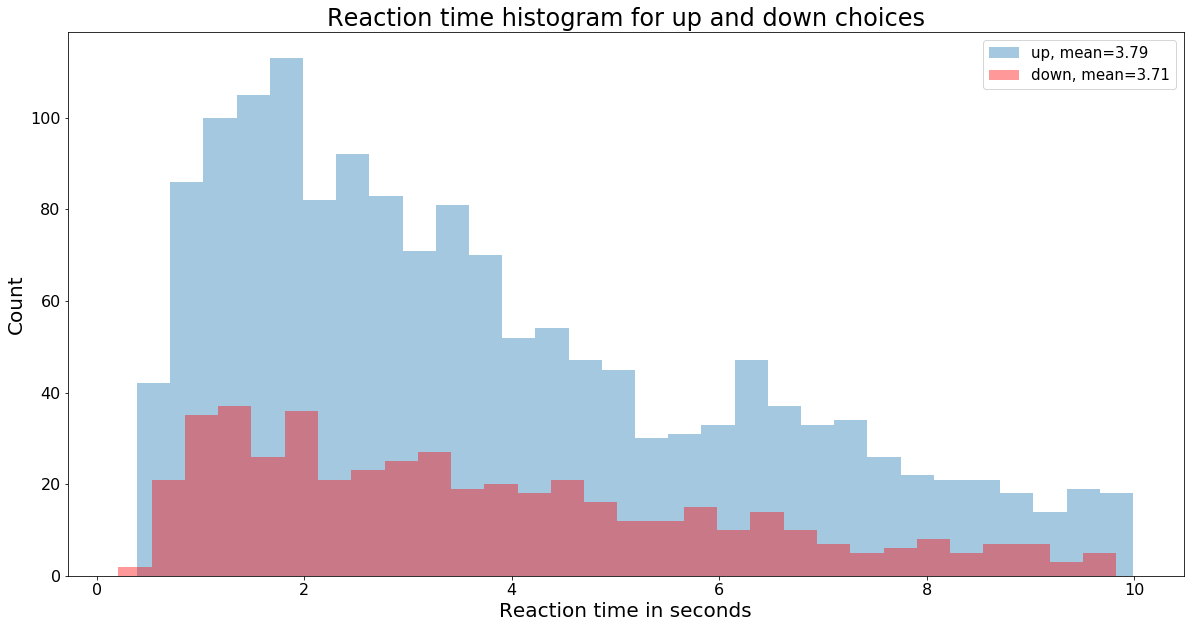

In [11]:
plt.figure(figsize=(20,10))
plt.hist(uprt, bins=30, alpha=.4)
plt.hist(downrt, bins=30, alpha=.4, color='r')

plt.title("Reaction time histogram for up and down choices")
plt.xlabel("Reaction time in seconds")
plt.ylabel("Count")
plt.legend(["up, mean={}".format(upmean), "down, mean={}".format(downmean)]);

#### Discussion
This is what we would expect: given that the drift mu is slightly positive there should be more 'up' decisions. The overall shape of the RT distributions, however, should be similar. The shape of the distributions reminds of an exponential or a Gamma distribution. 

The 'down' distribution is more flat compared to the 'up' distribution. One could argue that is due to the fact that 'down' decisions are driven more by the noise and less by the drift. 

As sufficient evidence is immediately available to the "subject", we would expect that the mean reaction time is rather in the order of hundred of ms instead of about 3-4 seconds. We see this, for example, in the experimental results of Gold and Shadlen (2007): figure 5b, for 70 \% correct responses the mean RT is about 800ms. 

#### b) 
Reproduce qualitatively figure 5b of Gold and Shadlen (2007): increased motion strength (which, loosely speaking, corresponds to increased drift $\mu$) results in higher percentage correct and reduced mean reaction times. 

In [12]:
# we model motion strength by ddm drift mu: 
n_steps = 5
n_trials = 1000
mus = np.linspace(0.01, .5, n_steps)
sigma = 0.5
a = 1
dt = 0.01
t = np.arange(0, 10, dt)

# given different values of we want to obtain percent correct and mean_rt 
percent_correct = np.zeros_like(mus)
mean_rt = np.zeros_like(mus)

In [13]:
# iterate over mus 
for idx, mu in enumerate(tqdm(mus, desc='mus')): 
    
    choices = np.zeros(n_trials)    
    rts = np.zeros(n_trials)    
    
    # simulate many trials 
    for i_trial in range(n_trials): 
        xtrace, check = simulate_ddm(mu, sigma, a)
        choices[i_trial], rts[i_trial] = get_choice_and_rt(xtrace, a, t)
    
    # since mu was positive, 'up' is the 'correct' decision
    # calculate percent correct 
    percent_correct[idx] = np.where(choices==1)[0].size / n_trials
    # calculate mean RT 
    mean_rt[idx] = rts.mean()

mus: 100%|██████████| 5/5 [00:46<00:00,  9.34s/it]


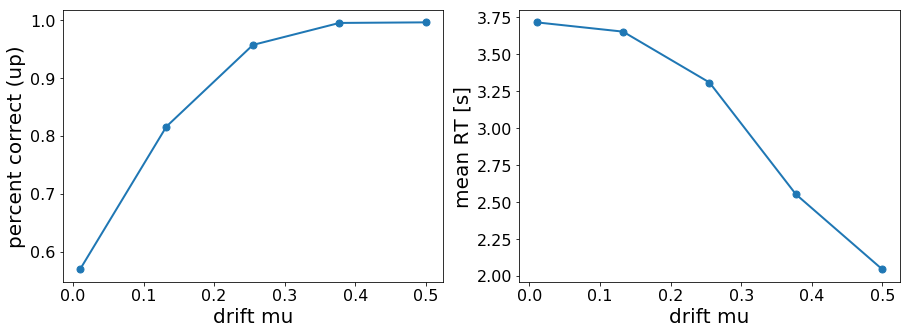

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

plt.sca(ax[0])
plt.plot(mus, percent_correct, '-o')
plt.xlabel('drift mu')
plt.ylabel('percent correct (up)')

plt.sca(ax[1])
plt.plot(mus, mean_rt, 'o-')
plt.xlabel('drift mu')
plt.ylabel('mean RT [s]');

### Part 5

Implement an extended version of the drift-diffusion model, in which the drift $\mu$
for each trial is drawn from a Gaussian distribution with mean $m_{\mu}$ and standard
deviation $s_{\mu}$ . Find values for $m_{\mu}$ and $s_{\mu}$ that keep $70\%$ ”up” rate but have reaction
time distributions that (qualitatively) fit experimental results better. Plot your
resulting distributions and mean reaction times for ”up” and ”down” responses
from 2000 trials.

## Ansatz: 
What does is mean to fit the experimental results better? We can reproduce figure 5b of Gold and Shadlen qualitatively, however, the mean RTs are way longer in our results. We therefore need to search for parameters of the mean $m_{\mu}$ and standard deviation $s_{\mu}$ such that the mean RTs reduce to around 700-1000ms while the percent correct remains the same: 

In [15]:
### Parameter gridsearch: we want that the mean reaction time is around ms instead of s

a = 1 # decision boundary
dt = 0.01
t = np.arange(0, 10, dt)

m_μs = np.linspace(.5, 2., 10)
s_μs = np.linspace(1.5, 3, 10)
sigma = 0.5

n_trials = 200

percent_correct = np.zeros((m_μs.size, s_μs.size))
mean_rt = np.zeros((m_μs.size, s_μs.size))

# debug print
# print('m_µ'.ljust(3), 's_µ'.ljust(3), 'pc'.ljust(3), 'RT'.ljust(3))

# manual progress bar for nested for loop: 
with tqdm(total=m_μs.size * s_μs.size, desc='grid search') as pbar:

    # iterate over mus 
    for i, m_μ in enumerate(m_μs): 
        # iterate over sigmas
        for j, s_μ in enumerate(s_μs):
            
            choices = np.zeros(n_trials)    
            rts = np.zeros(n_trials) 
            for k in range(n_trials):
                mu = np.random.normal(m_μ, s_μ)
                xtrace, check = simulate_ddm(mu, sigma, a)
                choices[k], rts[k] = get_choice_and_rt(xtrace, a, t)
            
            # calculate percent correct
            percent_correct[i, j] = np.where(choices==1)[0].size / n_trials
            
            # calculate mean RT 
            mean_rt[i, j] = rts.mean()
            
            # update progress bar
            pbar.update()
            # print to check results on the fly
    #         print(np.round(m_μ, 2), np.round(s_μ, 2), np.round(percent_correct[i, j], 2), np.round(mean_rt[i, j], 2))

grid search: 100%|██████████| 100/100 [02:58<00:00,  1.74s/it]


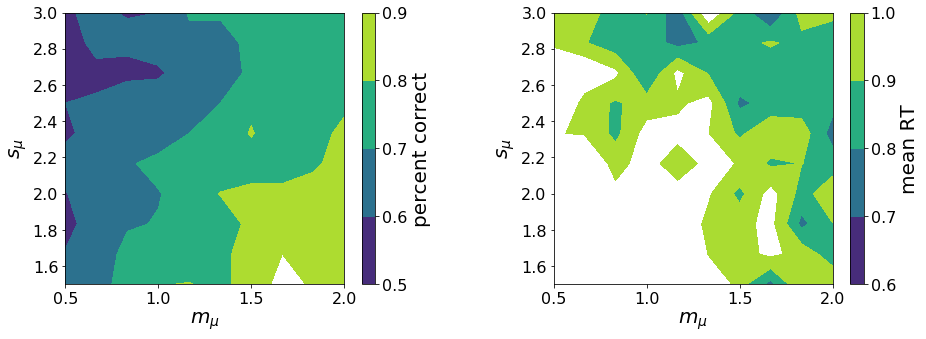

In [16]:
# lets plot the results
# choose contour levels we are interested in: 
levels_percent_correct = [.5, .6, .7, .8, .9]
levels_rt = [.6, .7, .8, .9, 1.]

fig = plt.figure(figsize=[15, 5])
ax = plt.subplot(1, 2, 1)
X, Y = np.meshgrid(m_μs, s_μs)
pc = ax.contourf(X, Y, percent_correct.T, levels=levels_percent_correct)
ax.set_xlabel('$m_\mu$')
ax.set_ylabel('$s_\mu$')
cb = plt.colorbar(mappable=pc, ax=ax)
cb.set_label("percent correct")

ax = plt.subplot(1, 2, 2)
X, Y = np.meshgrid(m_μs, s_μs)
pc = ax.contourf(X, Y, mean_rt.T, levels=levels_rt)
ax.set_xlabel('$m_\mu$')
ax.set_ylabel('$s_\mu$')
cb = plt.colorbar(mappable=pc, ax=ax)
cb.set_label("mean RT")
plt.subplots_adjust(wspace=0.4)

In [17]:
# from above we find that the region around m_mu=1.3 and m_sigma=2.8 results in pc~70% and rt~800ms
m_μ = 1.3 
s_μ = 2.8
sigma = 0.5

a = 1
dt = 0.01
t = np.arange(0, 10, dt)

n_trials = 2000
choices = np.zeros(n_trials)
rts = np.zeros(n_trials)

for i_trial in tqdm(range(n_trials), desc='trials'): 
    mu = np.random.normal(m_μ, s_μ)
    xtrace, check = simulate_ddm(mu, sigma, a)
    choices[i_trial], rts[i_trial] = get_choice_and_rt(xtrace, a, t)
    
uprt = rts[np.where(choices==1)[0]]
downrt = rts[np.where(choices==0)[0]]

upmean = round(np.mean(uprt),2)
downmean = round(np.mean(downrt),2)

trials: 100%|██████████| 2000/2000 [00:19<00:00, 101.56it/s]


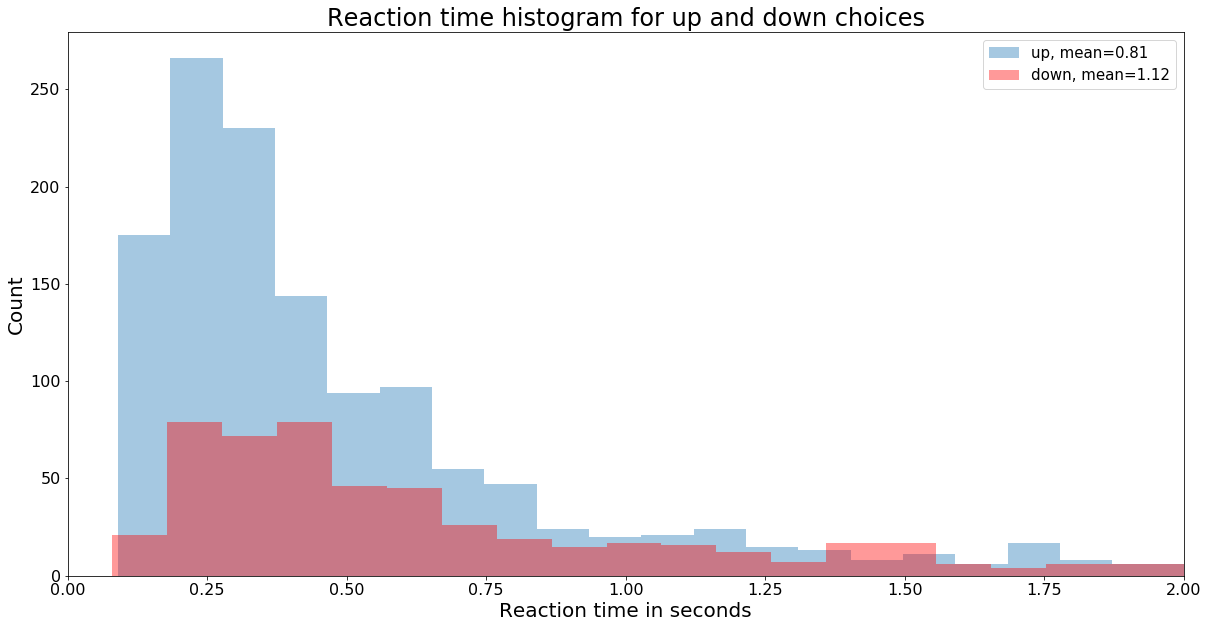

In [18]:
plt.figure(figsize=(20,10))
plt.hist(uprt, bins=100, alpha=.4)
plt.hist(downrt, bins=100, alpha=.4, color='r')
plt.xlim(0, 2)

plt.title("Reaction time histogram for up and down choices")
plt.xlabel("Reaction time in seconds")
plt.ylabel("Count")
plt.legend(["up, mean={}".format(upmean), "down, mean={}".format(downmean)]);

## Result 
Qualitatively the distributions look similar to the ones above. However, the reaction times are much shorter, resulting in mean reaction times that fit the experimental results (Gold & Shadlen, 2007) better. 